In [21]:
import Pkg; Pkg.activate("./"); Pkg.add("Revise"); Pkg.add("AdvancedHMC"); Pkg.add("Optim")

  Activating project at `~/workspace/ltdtms/examples`
   Resolving package versions...
  No Changes to `~/workspace/ltdtms/examples/Project.toml`
  No Changes to `~/workspace/ltdtms/examples/Manifest.toml`
   Resolving package versions...
  No Changes to `~/workspace/ltdtms/examples/Project.toml`
  No Changes to `~/workspace/ltdtms/examples/Manifest.toml`
   Resolving package versions...
    Updating `~/workspace/ltdtms/examples/Project.toml`
  [429524aa] + Optim v1.7.4
    Updating `~/workspace/ltdtms/examples/Manifest.toml`
  [30b0a656] + ArrayInterfaceCore v0.1.29
  [1a297f60] + FillArrays v0.13.7
  [6a86dc24] + FiniteDiff v2.17.0
  [d3d80556] + LineSearches v7.2.0
  [d41bc354] + NLSolversBase v7.8.3
  [429524aa] + Optim v1.7.4
  [d96e819e] + Parameters v0.12.3
  [85a6dd25] + PositiveFactorizations v0.2.4
  [4607b0f0] + SuiteSparse
Precompiling project...
  ✓ PositiveFactorizations
  ✓ Parameters
  ✓ ArrayInterfaceCore
  ✓ FillArrays
  ✓ FiniteDiff
  ✓ NLSolversBase
  ✓ LineSearches

In [14]:
using Revise

In [15]:
import BSON
inputdata = BSON.load("../test/inputdata.bson")

Dict{Symbol, Any} with 6 entries:
  :K          => 0.05
  :MT         => [0.25; 0.29; … ; 0.25; 0.24;;]
  :resolution => 0.001
  :EE         => [48.4617 219.505 90.7983; 54.7694 189.385 84.2952; … ; 54.5381…
  :Ethrprior  => 60.0
  :minThr     => 60.0

In [30]:
include("../src/LTDTMS.jl")
import .LTDTMS

In [131]:
thrdata = LTDTMS.makeThrData(inputdata);
MT_good = inputdata[:MT][:]
MT_bad = MT_good .* [1.15, 1, 1, 1, 1, 1]
EE = inputdata[:EE]
K = 0.05#inputdata[:K]
Ethrprior = 40.0 #inputdata[:Ethrprior]
Threads.nthreads()

1

In [132]:
display(thrdata.EE[:,:,1])
display(thrdata.EE[:,:,158])
display(MT_good)
display(MT_bad)

6×3 Matrix{Float64}:
 48.4617  219.505  90.7983
 54.7694  189.385  84.2952
 38.5813  190.498  82.8078
 57.6247  192.593  94.124
 54.5381  178.034  85.3645
 55.2336  207.397  89.734

6×3 Matrix{Float64}:
 135.772   268.696  92.1852
 136.089   218.577  87.9939
  93.8218  245.926  68.5635
 141.42    270.937  97.174
 138.496   260.54   93.9208
 141.46    273.272  94.5271

6-element Vector{Float64}:
 0.25
 0.29
 0.27
 0.24
 0.25
 0.24

6-element Vector{Float64}:
 0.2875
 0.29
 0.27
 0.24
 0.25
 0.24

In [133]:
using ThreadTools
thr_good = LTDTMS.ThrData(MT_good, EE, K, Ethrprior)
thr_bad = LTDTMS.ThrData(MT_bad, EE, K, Ethrprior)
@time stats_good = tmap(1:182) do site
    LTDTMS.get_site_stats(site, thr_good; n_samples=1500, n_adapts=100)
end
@time stats_bad = tmap(1:182) do site
    LTDTMS.get_site_stats(site, thr_bad; n_samples=1500, n_adapts=100)
end;


 72.836026 seconds (687.44 M allocations: 46.650 GiB, 15.74% gc time, 0.08% compilation time)
 75.615797 seconds (692.30 M allocations: 47.032 GiB, 14.70% gc time, 0.05% compilation time)


In [134]:
using Distributions

function sample_marginal_Ethr(stats, num=100)
    p = [s[1] for s in stats]
    p = p ./ sum(p)
    pCat = Categorical(p)
    len_s = length(stats[1][5])
    sCat = DiscreteUniform(1,len_s)
    s_rand = [stats_good[rand(pCat,1)[1]][5][rand(sCat,1)][1] for n in 1:num]
end

s_samples_good = sample_marginal_Ethr(stats_good, 10000) .|> (x->1 ./ (sum(x.^2)|>sqrt))
s_samples_bad = sample_marginal_Ethr(stats_bad, 10000) .|> (x->1 ./ (sum(x.^2)|>sqrt))

10000-element Vector{Float64}:
 51.16772181813095
 51.48516200606491
 39.90515104412524
 42.91920614665782
 62.008824858631066
 58.30190721966281
 46.7571429735717
 51.40938233424387
 68.35954178384546
 48.005178019667355
 40.91255242843937
 54.05093024647642
 49.686601737989434
  ⋮
 45.043316752072165
 48.036807019161316
 48.49151958149161
 41.57090079536866
 47.02882890230008
 54.31585666847762
 50.62480306410303
 39.820763469863046
 57.7686659690966
 44.560620116897866
 48.31758442853598
 49.08527991028927

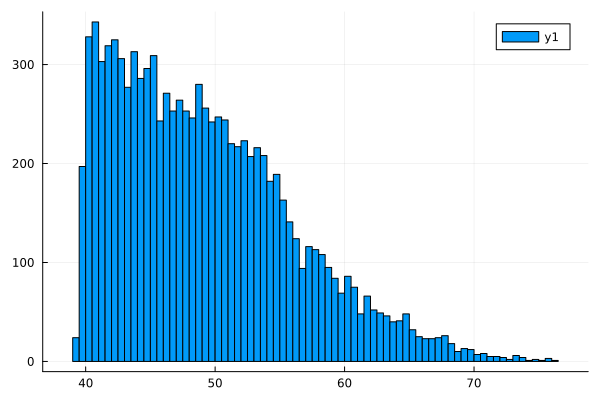

In [135]:
histogram(s_samples_bad; bins=100)

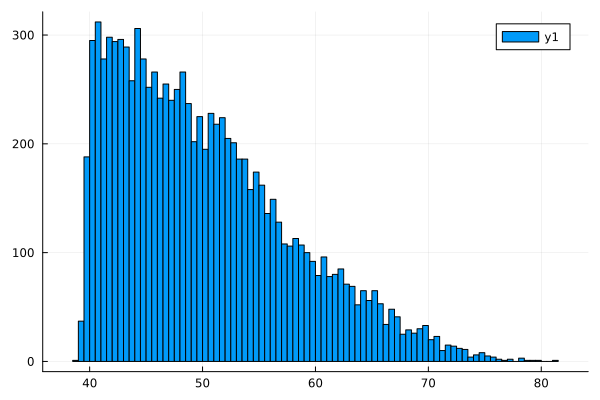

In [136]:
histogram(s_samples_good; bins=100)

### Ten largest (descending) normalizing coeff indices for bad (left) and good (right) MTs:


11×4 Matrix{Float64}:
  95.0      1.12962e5  158.0  4.789e6
  96.0      1.06373e5  163.0  4.66117e6
 131.0      1.01993e5  130.0  4.39513e6
  87.0  77839.6        129.0  4.10649e6
  51.0  73820.0         94.0  3.69563e6
 159.0  63817.4        136.0  3.63953e6
 124.0  59055.0        135.0  3.58137e6
 130.0  57869.9        101.0  3.39343e6
  86.0  57021.7         95.0  3.21604e6
 164.0  49220.5        157.0  2.8358e6
 160.0  45915.4        177.0  2.81013e6

The locations are quite near each other but because the electric field data is reordered to `N_mt x 3 x N_site` matrix, physical adjecency from site index values cannot be exactly assessed.


### Preferred directions at MAP location:

**Bad MTs**:


3-element Vector{Float64}:
 0.28715575617355193
 0.8210739825492007
 0.284967513416965

**Good MTs**: 


3-element Vector{Float64}:
 0.20020948409466996
 0.8640220724418326
 0.1696289535614967

### Electric field thresholds at MAP location (V/m)

**Bad MTs**:


64.8137457419166

**Good MTs**: 


67.08684974264489

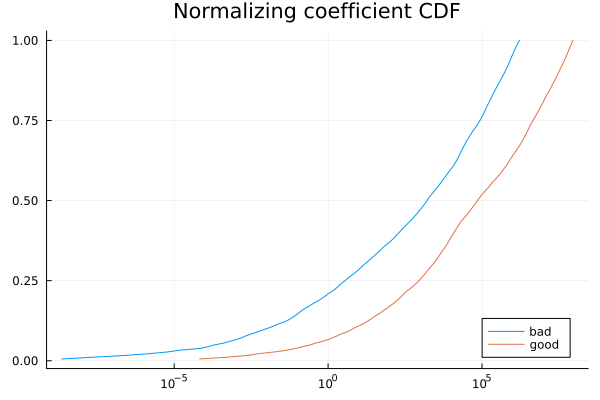

In [7]:
using Plots, Markdown
let Z = Dict(:good=>[stat[1] for stat in stats_good], :bad => [stat[1] for stat in stats_bad]),
        fig = plot()
    plotter(z, label) = plot!(fig, z, (1:length(z)) ./ length(z), label=label, legend=:bottomright, title="Normalizing coefficient CDF", xaxis=:log)
    perm_bad = sortperm(Z[:bad])
    perm_good = sortperm(Z[:good])
    sort(Z[:bad])|>cumsum |> z->plotter(z, "bad")
    sort(Z[:good])|>cumsum |> z->plotter(z, "good")
    
    md"### Ten largest (descending) normalizing coeff indices for bad (left) and good (right) MTs:"|>display
    [perm_bad[end:-1:172] Z[:bad][perm_bad[end:-1:172]] perm_good[end:-1:172] Z[:good][perm_good[end:-1:172]]] |> display
    
    md"The locations are quite near each other but because the electric field data is reordered to `N_mt x 3 x N_site` matrix, physical adjecency from site index values cannot be exactly assessed."|>display
    md"""### Preferred directions at MAP location:
    
    **Bad MTs**:""" |>display
    stats_bad[perm_bad[end]][4]|>display
    
    md"**Good MTs**: " |> display
    stats_good[perm_good[end]][4] |>display
    
    md"""### Electric field thresholds at MAP location (V/m)
    **Bad MTs**:""" |>display
    stats_bad[perm_bad[end]][3]|>display
    
    md"**Good MTs**: " |> display
    stats_good[perm_good[end]][3] |>display
    
    fig
end